# VGG16 Transfer Learning on CBIS DDSM

This notebook exploits Transfer Learning on the VGG16 CNN architecture (pre-trained on ImageNet) for abnormality classification (mass-calcification) on mammography images taken from the CBIS DDSM dataset.

# Environment setup

In [2]:
cbis_path = 'C:/Users/CHRISTIANAH/Documents/Aaaa/DS/CBIS_DDSM'

In [3]:
# Import libraries

#%tensorflow_version 1.x
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

# Data pre-processing

In [6]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [7]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 256
test_images = test_images.astype('uint16') / 256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2676 	 Test size: 336
Image size: 150x150


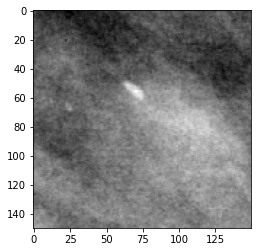

Label: 1


In [5]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

# VGG16

## Model definition

In [6]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(150, 150, 3))

    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(1, activation='sigmoid'))

    # Freeze the convolutional base
    vgg16_base.trainable = False

    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [7]:
# Show the VGG16 architecture

vgg16_example = create_vgg16(verbose=True)
plot_model(vgg16_example, to_file='vgg16.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

58900480/58889256 [==============================] - 17s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                             

## Feature extraction

### Vanilla

In [15]:
def create_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)  # Global average pooling instead of Flatten
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)  # For binary classification
    model = models.Model(inputs=base_model.input, outputs=x)
    
    # Freeze the layers except the last 4 layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False
        
    return model



vgg16_fe = create_vgg16()

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
    'vgg16_fe_2cl_best.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True, 
    save_freq='epoch'
)

# Compile the model
vgg16_fe.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Use `train_generator.n` and `validation_generator.n` to get the number of images
n_train_img = train_generator.n
n_val_img = validation_generator.n

steps_per_epoch = n_train_img // train_generator.batch_size
validation_steps = n_val_img // validation_generator.batch_size

# Train the model
history_vgg16_fe = vgg16_fe.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=200,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, earlystopping],
    shuffle=True,
    verbose=1,
    initial_epoch=0
)


# Define the model save paths
model_save_path = 'vgg16_fe_2cl_end.h5'
destination_dir = "C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/"
destination_path = os.path.join(destination_dir, 'vgg16_fe_2cl_end.h5')

# Save the model to the working directory
models.save_model(vgg16_fe, model_save_path)

# Check if the destination directory exists, if not, create it
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Save the model to the destination directory
models.save_model(vgg16_fe, destination_path)

# Confirm that the model has been saved
if os.path.exists(model_save_path) and os.path.exists(destination_path):
    print(f"Model saved successfully at {model_save_path} and {destination_path}")
else:
    print("Error: Model not saved.")


Epoch 1/200
16/16 [==============================] - ETA: 0s - loss: 50.5994 - accuracy: 0.5306 
Epoch 1: val_loss improved from inf to 0.69454, saving model to vgg16_fe_2cl_best.h5
16/16 [==============================] - 489s 31s/step - loss: 50.5994 - accuracy: 0.5306 - val_loss: 0.6945 - val_accuracy: 0.4980
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.5479 
Epoch 2: val_loss did not improve from 0.69454
16/16 [==============================] - 505s 32s/step - loss: 0.6915 - accuracy: 0.5479 - val_loss: 0.6948 - val_accuracy: 0.5098
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.5479 
Epoch 3: val_loss improved from 0.69454 to 0.68993, saving model to vgg16_fe_2cl_best.h5
16/16 [==============================] - 493s 31s/step - loss: 0.7090 - accuracy: 0.5479 - val_loss: 0.6899 - val_accuracy: 0.6094
Epoch 4/200
16/16 [==============================] - ETA: 0s - loss: 0.7185 - accuracy: 0.5420 


In [19]:
# # Evaluate the model
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

# test_loss_fe, test_acc_fe = vgg16_fe.evaluate(test_generator, verbose=False)

# print("Test accuracy:  %.4f" % test_acc_fe)
# print("Test loss:  %.4f" % test_loss_fe)

Test accuracy:  0.4673
Test loss:  0.7063


In [21]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Assuming history_vgg16_fe is already available from the training phase

# History of accuracy and loss
tra_loss_fe = history_vgg16_fe.history['loss']
tra_acc_fe = history_vgg16_fe.history['accuracy']
val_loss_fe = history_vgg16_fe.history['val_loss']
val_acc_fe = history_vgg16_fe.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe) + 1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe - 1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe - 1]

# Preprocess the test images as well
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

# Load the best model and evaluate on test set
opt_vgg16_fe = load_model('vgg16_fe_2cl_best.h5')

# Ensure input shapes match for evaluation
test_loss_fe, test_acc_fe = vgg16_fe.evaluate(test_generator, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe.evaluate(test_generator, verbose=False)

print("VGG16 Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)


VGG16 Feature Extraction

Epoch [end]: 35
Epoch [opt]: 5
Valid accuracy [end]: 0.5078
Valid accuracy [opt]: 0.5039
Test accuracy [end]:  0.4673
Test accuracy [opt]:  0.4673
Valid loss [end]: 0.6974
Valid loss [opt]: 0.6876
Test loss [end]:  0.7063
Test loss [opt]:  0.6929


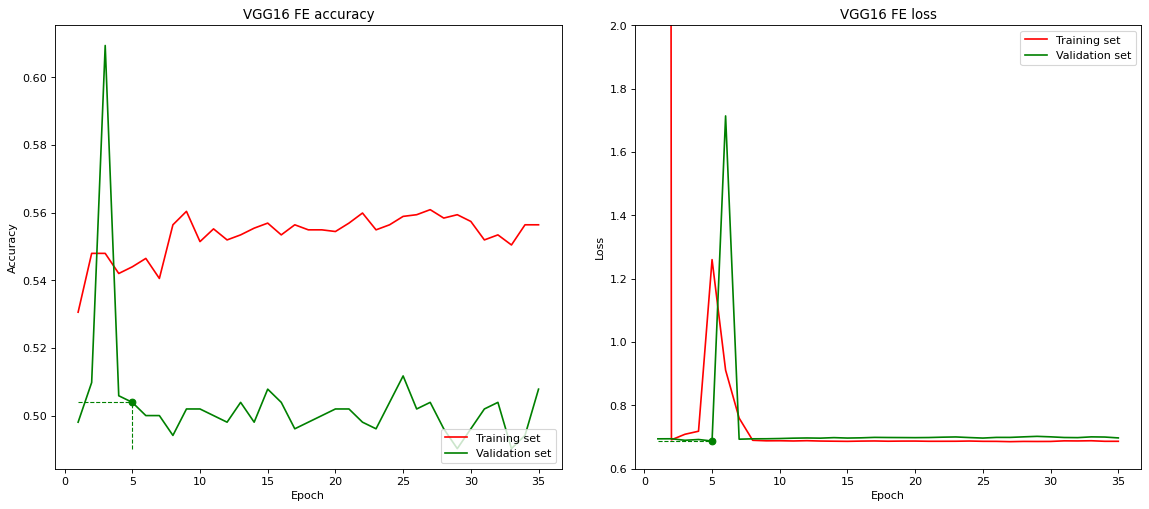

In [24]:
import matplotlib.pyplot as plt

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), dpi=80)

# Plot accuracy
ax1.set_title('VGG16 FE accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
ax1.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
ax1.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
ax1.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
ax1.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
ax1.legend(loc='lower right')

# Plot loss
ax2.set_title('VGG16 FE loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylim(0.6, 2.0)
ax2.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
ax2.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
ax2.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
ax2.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
ax2.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
ax2.legend()

# Adjust layout to ensure there is space between plots
plt.tight_layout(pad=3.0)

# Show the plots
plt.show()

### With dropout

In [26]:
# Define the create_vgg16 function with a dropout parameter
def create_vgg16(dropout=None, fc_size=256, verbose=False):
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)
    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(1, activation='sigmoid'))

    # Freeze the convolutional base
    vgg16_base.trainable = False

    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop = create_vgg16(dropout=0.5)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Assuming train_generator and validation_generator are already defined
n_train_img = train_generator.n
n_val_img = validation_generator.n

steps_per_epoch = n_train_img // train_generator.batch_size
validation_steps = n_val_img // validation_generator.batch_size

# Train
history_vgg16_fe_drop = vgg16_fe_drop.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=200,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Define the model save paths
model_save_path = 'vgg16_fe_drop_2cl_end.h5'
destination_dir = "C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/"
destination_path = os.path.join(destination_dir, 'vgg16_fe_drop_2cl_end.h5')

# Save the model to the working directory
vgg16_fe_drop.save(model_save_path)

# Check if the destination directory exists, if not, create it
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Save the model to the destination directory
vgg16_fe_drop.save(destination_path)

# Confirm that the model has been saved
if os.path.exists(model_save_path) and os.path.exists(destination_path):
    print(f"Model saved successfully at {model_save_path} and {destination_path}")
else:
    print("Error: Model not saved.")

Epoch 1/200
16/16 [==============================] - ETA: 0s - loss: 1.9055 - accuracy: 0.7149 
Epoch 1: val_loss improved from inf to 0.52888, saving model to vgg16_fe_drop_2cl_best.h5
16/16 [==============================] - 517s 32s/step - loss: 1.9055 - accuracy: 0.7149 - val_loss: 0.5289 - val_accuracy: 0.7480
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.4907 - accuracy: 0.8112 
Epoch 2: val_loss improved from 0.52888 to 0.47742, saving model to vgg16_fe_drop_2cl_best.h5
16/16 [==============================] - 447s 28s/step - loss: 0.4907 - accuracy: 0.8112 - val_loss: 0.4774 - val_accuracy: 0.8223
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.4700 - accuracy: 0.8008 
Epoch 3: val_loss improved from 0.47742 to 0.46893, saving model to vgg16_fe_drop_2cl_best.h5
16/16 [==============================] - 434s 28s/step - loss: 0.4700 - accuracy: 0.8008 - val_loss: 0.4689 - val_accuracy: 0.7598
Epoch 4/200
16/16 [======================

In [27]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop.history['loss']
tra_acc_fe = history_vgg16_fe_drop.history['accuracy']
val_loss_fe = history_vgg16_fe_drop.history['val_loss']
val_acc_fe = history_vgg16_fe_drop.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe) + 1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe - 1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe - 1]

# Preprocess the test images as well
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

# Load the best model and evaluate on test set
opt_vgg16_fe = models.load_model('vgg16_fe_drop_2cl_best.h5')

# Ensure input shapes match for evaluation
test_loss_fe, test_acc_fe = vgg16_fe_drop.evaluate(test_generator, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe.evaluate(test_generator, verbose=False)

print("VGG16 (with dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (with dropout) Feature Extraction

Epoch [end]: 78
Epoch [opt]: 48
Valid accuracy [end]: 0.8730
Valid accuracy [opt]: 0.8750
Test accuracy [end]:  0.8244
Test accuracy [opt]:  0.8244
Valid loss [end]: 0.3491
Valid loss [opt]: 0.3125
Test loss [end]:  0.7754
Test loss [opt]:  0.7049


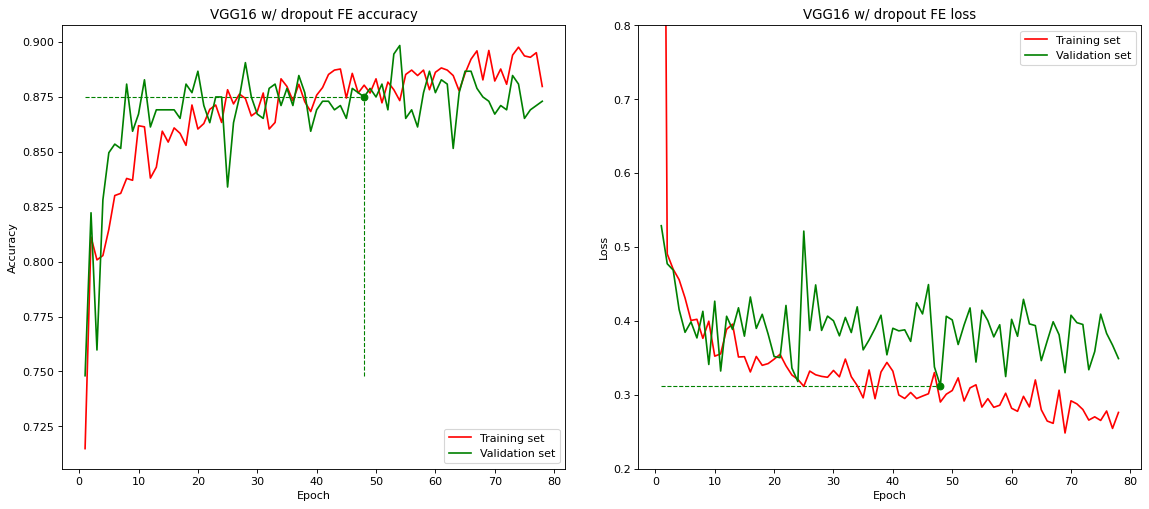

In [29]:
# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), dpi=80)

# Plot accuracy
ax1.set_title('VGG16 w/ dropout FE accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
ax1.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
ax1.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
ax1.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
ax1.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
ax1.legend(loc='lower right')

# Plot loss
ax2.set_title('VGG16 w/ dropout FE loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylim(0.2, 0.8)
ax2.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
ax2.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
ax2.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
ax2.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
ax2.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
ax2.legend()

# Adjust layout to ensure there is space between plots
plt.tight_layout(pad=3.0)

# Show the plots
plt.show()

### With dropout and smaller FC

In [30]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)



# Define the model save paths
model_save_path = 'vgg16_fe_drop_128_2cl_end.h5'
destination_dir = "C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/"
destination_path = os.path.join(destination_dir, 'vgg16_fe_drop_128_2cl_end.h5')

# Save the model to the working directory
models.save_model(vgg16_fe_drop_128, model_save_path)

# Check if the destination directory exists, if not, create it
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Save the model to the destination directory
models.save_model(vgg16_fe_drop_128, destination_path)

# Confirm that the model has been saved
if os.path.exists(model_save_path) and os.path.exists(destination_path):
    print(f"Model saved successfully at {model_save_path} and {destination_path}")
else:
    print("Error: Model not saved.")

<ipython-input-30-e7137c2214a6>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(


Epoch 1/200
16/16 [==============================] - ETA: 0s - loss: 1.5208 - accuracy: 0.7109 
Epoch 1: val_loss improved from inf to 0.45436, saving model to vgg16_fe_drop_128_2cl_best.h5
16/16 [==============================] - 459s 28s/step - loss: 1.5208 - accuracy: 0.7109 - val_loss: 0.4544 - val_accuracy: 0.7963
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.4938 - accuracy: 0.7978 
Epoch 2: val_loss improved from 0.45436 to 0.40501, saving model to vgg16_fe_drop_128_2cl_best.h5
16/16 [==============================] - 469s 30s/step - loss: 0.4938 - accuracy: 0.7978 - val_loss: 0.4050 - val_accuracy: 0.8280
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.4514 - accuracy: 0.8018 
Epoch 3: val_loss improved from 0.40501 to 0.39980, saving model to vgg16_fe_drop_128_2cl_best.h5
16/16 [==============================] - 434s 27s/step - loss: 0.4514 - accuracy: 0.8018 - val_loss: 0.3998 - val_accuracy: 0.8206
Epoch 4/200
16/16 [==========

In [32]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_2cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 36
Epoch [opt]: 16
Valid accuracy [end]: 0.8692
Valid accuracy [opt]: 0.8748
Test accuracy [end]:  0.8720
Test accuracy [opt]:  0.8304
Valid loss [end]: 0.4336
Valid loss [opt]: 0.3335
Test loss [end]:  0.3813
Test loss [opt]:  0.4303


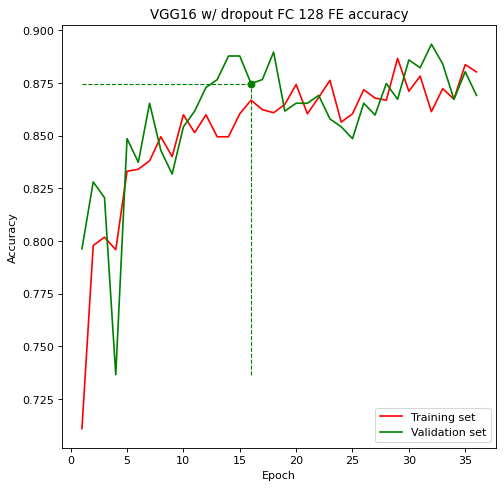

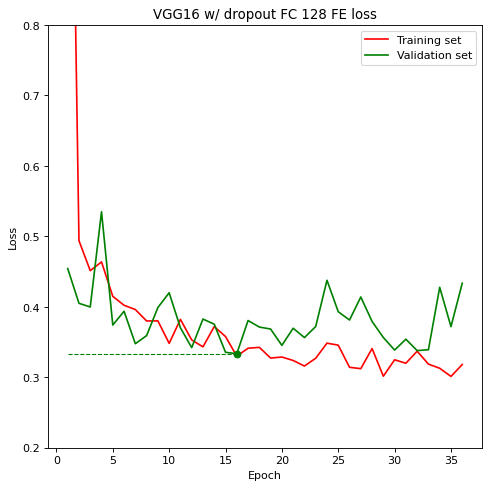

In [33]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.2, 0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Harder data augmentation

In [34]:
# New generator with more aggressive data augmentation parameters
train_datagen_hardaugm = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

train_datagen_hardaugm.fit(train_images)

train_generator_hardaugm = train_datagen_hardaugm.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator_hardaugm = train_datagen_hardaugm.flow(train_images, train_labels, batch_size=128, subset='validation')

In [35]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_hardaugm = create_vgg16(dropout=0.5)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_hardaugm_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_hardaugm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_vgg16_fe_hardaugm = vgg16_fe_hardaugm.fit_generator(
        train_generator_hardaugm,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator_hardaugm,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)



# Define the model save paths
model_save_path = 'vgg16_fe_hardaugm_2cl_end.h5'
destination_dir = "C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/"
destination_path = os.path.join(destination_dir, 'vgg16_fe_hardaugm_2cl_end.h5')

# Save the model to the working directory
models.save_model(vgg16_fe_hardaugm, model_save_path)

# Check if the destination directory exists, if not, create it
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Save the model to the destination directory
models.save_model(vgg16_fe_hardaugm, destination_path)

# Confirm that the model has been saved
if os.path.exists(model_save_path) and os.path.exists(destination_path):
    print(f"Model saved successfully at {model_save_path} and {destination_path}")
else:
    print("Error: Model not saved.")

<ipython-input-35-67d78186bbde>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg16_fe_hardaugm = vgg16_fe_hardaugm.fit_generator(


Epoch 1/200
16/16 [==============================] - ETA: 0s - loss: 2.3032 - accuracy: 0.6826 
Epoch 1: val_loss improved from inf to 0.47739, saving model to vgg16_fe_hardaugm_2cl_best.h5
16/16 [==============================] - 447s 28s/step - loss: 2.3032 - accuracy: 0.6826 - val_loss: 0.4774 - val_accuracy: 0.7832
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.5235 - accuracy: 0.7685 
Epoch 2: val_loss improved from 0.47739 to 0.44859, saving model to vgg16_fe_hardaugm_2cl_best.h5
16/16 [==============================] - 438s 28s/step - loss: 0.5235 - accuracy: 0.7685 - val_loss: 0.4486 - val_accuracy: 0.8150
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.7859 
Epoch 3: val_loss improved from 0.44859 to 0.44427, saving model to vgg16_fe_hardaugm_2cl_best.h5
16/16 [==============================] - 434s 27s/step - loss: 0.4971 - accuracy: 0.7859 - val_loss: 0.4443 - val_accuracy: 0.7944
Epoch 4/200
16/16 [==========

In [36]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_hardaugm.history['loss']
tra_acc_fe = history_vgg16_fe_hardaugm.history['accuracy']
val_loss_fe = history_vgg16_fe_hardaugm.history['val_loss']
val_acc_fe = history_vgg16_fe_hardaugm.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_hardaugm = models.load_model('vgg16_fe_hardaugm_2cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_hardaugm.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_hardaugm.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout, hard augmentation) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, hard augmentation) Feature Extraction

Epoch [end]: 103
Epoch [opt]: 73
Valid accuracy [end]: 0.8430
Valid accuracy [opt]: 0.8486
Test accuracy [end]:  0.8720
Test accuracy [opt]:  0.8601
Valid loss [end]: 0.3595
Valid loss [opt]: 0.3253
Test loss [end]:  0.3649
Test loss [opt]:  0.3896


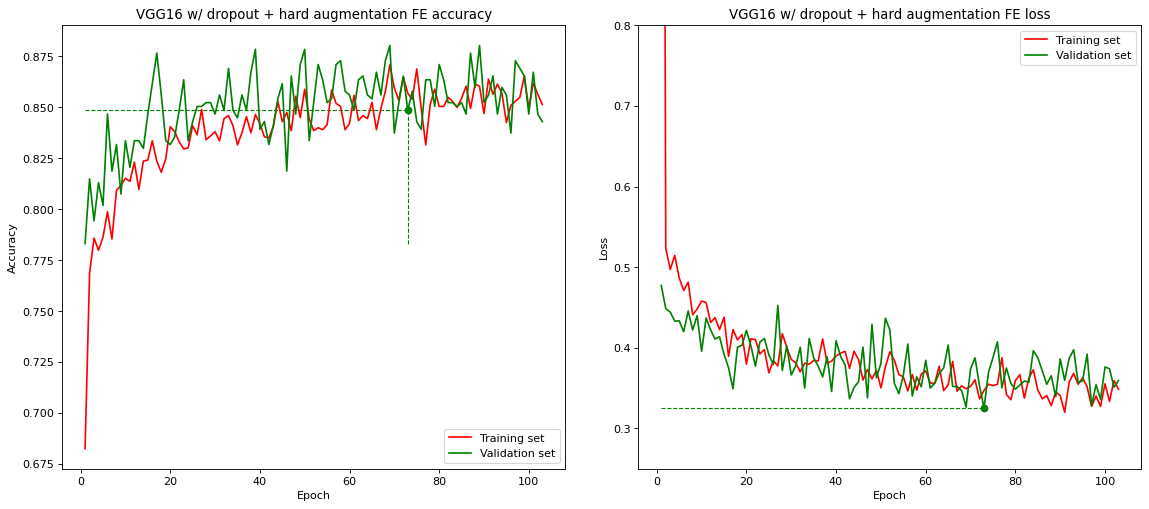

In [38]:
# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), dpi=80)

# Plot accuracy
ax1.set_title('VGG16 w/ dropout + hard augmentation FE accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
ax1.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
ax1.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
ax1.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
ax1.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
ax1.legend(loc='lower right')

# Plot loss
ax2.set_title('VGG16 w/ dropout + hard augmentation FE loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylim(0.25, 0.8)
ax2.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
ax2.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
ax2.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
ax2.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
ax2.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
ax2.legend()

# Adjust layout to ensure there is space between plots
plt.tight_layout(pad=3.0)

# Show the plots
plt.show()


## Fine tuning

### 1 layer

In [42]:
import shutil

# Define the source and destination paths
#C:\Users\CHRISTIANAH\Documents\Aaaa\DS\models
# source_path = "C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/vgg16_fe_hardaugm_2cl_best.h5"
destination_path = "./vgg16_fe_hardaugm_2cl_best.h5"

# # Copy the file from source to destination
# shutil.copy(source_path, destination_path)

# Load the model
vgg16_ft_1layer = load_model(destination_path)

# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model
vgg16_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summaries
vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_8 (Dropout)         (None, 8192)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               2097408   
                                                                 
 dense_21 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 4,457,473
Non-trainable params: 12,354,880
_________________________________________________________________
Model: "vgg16"
___________________

In [43]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_2cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator_hardaugm,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator_hardaugm,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


# Define the model save paths
model_save_path = 'vgg16_ft_1layer_2cl_end.h5'
destination_dir = "C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/"
destination_path = os.path.join(destination_dir, 'vgg16_ft_1layer_2cl_end.h5')

# Save the model to the working directory
models.save_model(vgg16_ft_1layer, model_save_path)

# Check if the destination directory exists, if not, create it
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Save the model to the destination directory
models.save_model(vgg16_ft_1layer, destination_path)

# Confirm that the model has been saved
if os.path.exists(model_save_path) and os.path.exists(destination_path):
    print(f"Model saved successfully at {model_save_path} and {destination_path}")
else:
    print("Error: Model not saved.")

<ipython-input-43-3a398d62a80e>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_ft = vgg16_ft_1layer.fit_generator(


Epoch 1/200
16/16 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.8455 
Epoch 1: val_loss improved from inf to 0.33097, saving model to vgg16_ft_1layer_2cl_best.h5
16/16 [==============================] - 480s 29s/step - loss: 0.3880 - accuracy: 0.8455 - val_loss: 0.3310 - val_accuracy: 0.8598
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.3527 - accuracy: 0.8530 
Epoch 2: val_loss improved from 0.33097 to 0.31878, saving model to vgg16_ft_1layer_2cl_best.h5
16/16 [==============================] - 442s 28s/step - loss: 0.3527 - accuracy: 0.8530 - val_loss: 0.3188 - val_accuracy: 0.8766
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8698 
Epoch 3: val_loss improved from 0.31878 to 0.30952, saving model to vgg16_ft_1layer_2cl_best.h5
16/16 [==============================] - 433s 27s/step - loss: 0.3263 - accuracy: 0.8698 - val_loss: 0.3095 - val_accuracy: 0.8673
Epoch 4/200
16/16 [================

In [44]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_2cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 130
Epoch [opt]: 100
Valid accuracy [end]: 0.9028
Valid accuracy [opt]: 0.8953
Test accuracy [end]:  0.8810
Test accuracy [opt]:  0.8631
Valid loss [end]: 0.2672
Valid loss [opt]: 0.2305
Test loss [end]:  0.3874
Test loss [opt]:  0.3551


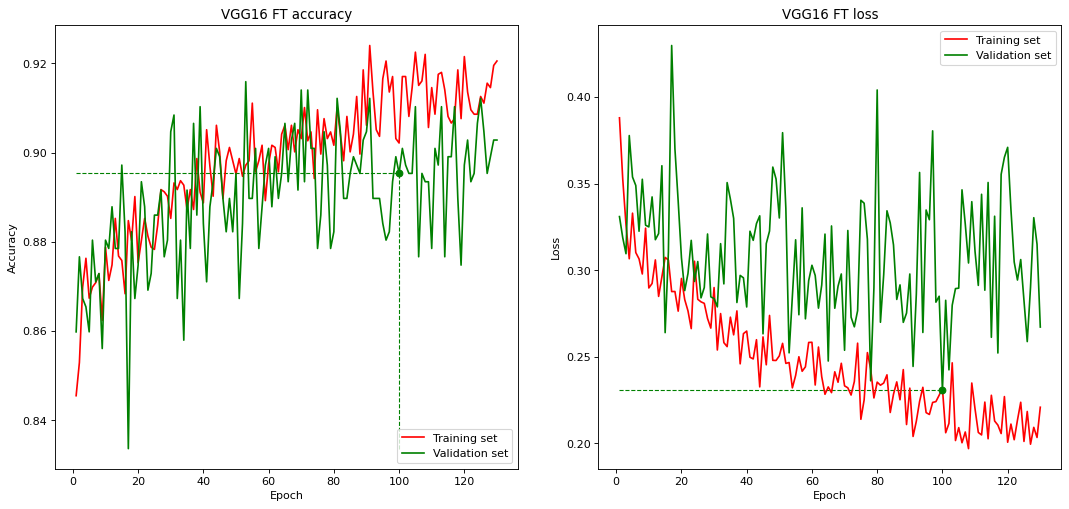

In [46]:
# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), dpi=80, facecolor='w', edgecolor='k')

# Plot accuracy
ax1.set_title('VGG16 FT accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
ax1.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
ax1.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
ax1.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
ax1.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
ax1.legend(loc='lower right')

# Plot loss
ax2.set_title('VGG16 FT loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
ax2.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
ax2.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
ax2.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
ax2.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
ax2.legend()

# Adjust layout to ensure there is space between plots
plt.tight_layout(pad=3.0)

# Show the plots
plt.show()


### 2 layers

In [47]:
#!cp "C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/vgg16_ft_1layer_2cl_best.h5" .
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_2cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_8 (Dropout)         (None, 8192)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               2097408   
                                                                 
 dense_21 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 6,817,281
Non-trainable params: 9,995,072
_________________________________________________________________
Model: "vgg16"
____________________

In [48]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_2cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator_hardaugm,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator_hardaugm,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)




# Define the model save paths
model_save_path = 'vgg16_ft_2layer_2cl_end.h5'
destination_dir = "C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/"
destination_path = os.path.join(destination_dir, 'vgg16_ft_2layer_2cl_end.h5')

# Save the model to the working directory
models.save_model(vgg16_ft_2layer, model_save_path)

# Check if the destination directory exists, if not, create it
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Save the model to the destination directory
models.save_model(vgg16_ft_2layer, destination_path)

# Confirm that the model has been saved
if os.path.exists(model_save_path) and os.path.exists(destination_path):
    print(f"Model saved successfully at {model_save_path} and {destination_path}")
else:
    print("Error: Model not saved.")

<ipython-input-48-83ff0f2d0db3>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_ft_2layer = vgg16_ft_2layer.fit_generator(


Epoch 1/200
16/16 [==============================] - ETA: 0s - loss: 0.6664 - accuracy: 0.8241 
Epoch 1: val_loss improved from inf to 0.30239, saving model to vgg16_ft_2layer_2cl_best.h5
16/16 [==============================] - 557s 34s/step - loss: 0.6664 - accuracy: 0.8241 - val_loss: 0.3024 - val_accuracy: 0.8617
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.8743 
Epoch 2: val_loss improved from 0.30239 to 0.27685, saving model to vgg16_ft_2layer_2cl_best.h5
16/16 [==============================] - 502s 32s/step - loss: 0.2866 - accuracy: 0.8743 - val_loss: 0.2769 - val_accuracy: 0.8991
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.3088 - accuracy: 0.8726 
Epoch 3: val_loss did not improve from 0.27685
16/16 [==============================] - 481s 30s/step - loss: 0.3088 - accuracy: 0.8726 - val_loss: 0.2777 - val_accuracy: 0.8897
Epoch 4/200
16/16 [==============================] - ETA: 0s - loss: 0.2620 - accura

In [49]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_2cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 49
Epoch [opt]: 19
Valid accuracy [end]: 0.8486
Valid accuracy [opt]: 0.9009
Test accuracy [end]:  0.8601
Test accuracy [opt]:  0.8720
Valid loss [end]: 0.4267
Valid loss [opt]: 0.2481
Test loss [end]:  0.4178
Test loss [opt]:  0.4020


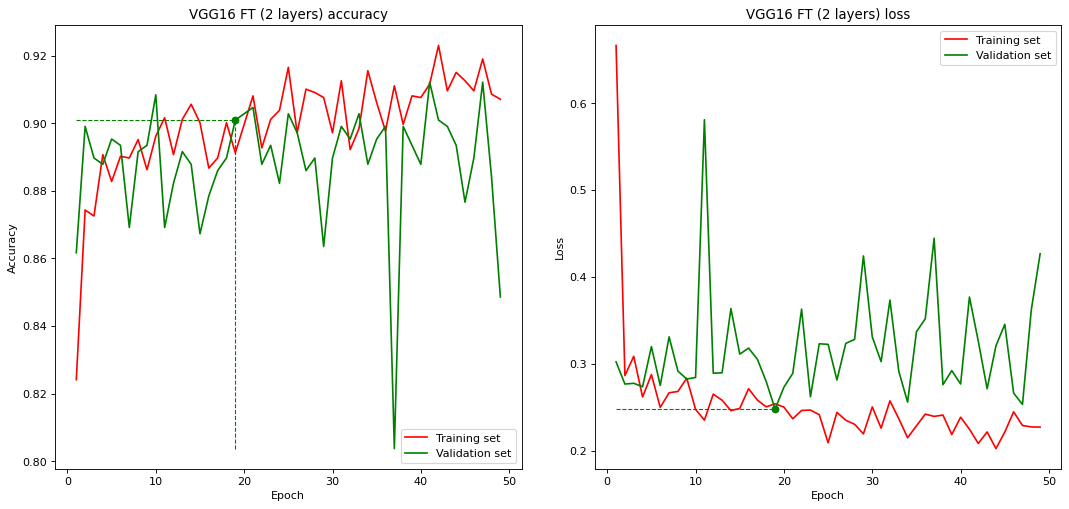

In [50]:
import matplotlib.pyplot as plt

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), dpi=80, facecolor='w', edgecolor='k')
 
# Plot accuracy
ax1.set_title('VGG16 FT (2 layers) accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
ax1.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
ax1.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
ax1.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
ax1.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
ax1.legend(loc='lower right')

# Plot loss
ax2.set_title('VGG16 FT (2 layers) loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
ax2.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
ax2.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
ax2.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
ax2.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
ax2.legend()

# Adjust layout to ensure there is space between plots
plt.tight_layout(pad=3.0)

# Show the plots
plt.show()


COMPARING WITH CNN

In [8]:
import os
from tensorflow.keras import models

model_dir = 'C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/'
model_path = os.path.join(model_dir, 'vgg16_ft_2layer_2cl_best.h5')

modelvgg = models.load_model(model_path)

In [9]:
# Assuming test_images and test_labels are properly defined
y_pred = modelvgg.predict(test_images)

In [10]:
import numpy as np

y_pred_classes = np.argmax(y_pred, axis=1)

In [11]:
from sklearn.metrics import classification_report

# Assuming test_labels are the true labels corresponding to test_images
class_report = classification_report(test_labels, y_pred_classes)

print(class_report)

              precision    recall  f1-score   support

           0       0.53      1.00      0.70       179
           1       0.00      0.00      0.00       157

    accuracy                           0.53       336
   macro avg       0.27      0.50      0.35       336
weighted avg       0.28      0.53      0.37       336



C:\Users\CHRISTIANAH\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CHRISTIANAH\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CHRISTIANAH\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
import pandas as pd

# Load the CSV file into a DataFrame
top_models_loaded = pd.read_csv('top_models.csv')

# Display the loaded DataFrame
print(top_models_loaded)

top_models_loaded

   index  Epochs End  Epochs Opt  Valid Accuracy End  Valid Accuracy Opt  \
0      3         256         216              0.9028              0.9065   
1      4         349         269              0.8916              0.9196   
2      9         463         383              0.8654              0.8822   

   Test Accuracy End  Test Accuracy Opt  Valid Loss End  Valid Loss Opt  \
0             0.8542             0.8750          0.2941          0.2094   
1             0.8690             0.8720          0.2626          0.1962   
2             0.8661             0.8601          0.3629          0.3326   

   Test Loss End  Test Loss Opt  Precision  Recall  F1 Score  \
0         0.3679         0.3389     0.8744  0.8756    0.8747   
1         0.3604         0.3527     0.8734  0.8697    0.8709   
2         0.3682         0.3359     0.8613  0.8578    0.8589   

   Number of Wrong Predictions  Number of Hard Predictions  
0                           42                          12  
1              

,index,Epochs End,Epochs Opt,Valid Accuracy End,Valid Accuracy Opt,Test Accuracy End,Test Accuracy Opt,Valid Loss End,Valid Loss Opt,Test Loss End,Test Loss Opt,Precision,Recall,F1 Score,Number of Wrong Predictions,Number of Hard Predictions
0,3,256,216,0.9028,0.9065,0.8542,0.8750,0.2941,0.2094,0.3679,0.3389,0.8744,0.8756,0.8747,42,12
1,4,349,269,0.8916,0.9196,0.8690,0.8720,0.2626,0.1962,0.3604,0.3527,0.8734,0.8697,0.8709,43,19
2,9,463,383,0.8654,0.8822,0.8661,0.8601,0.3629,0.3326,0.3682,0.3359,0.8613,0.8578,0.8589,47,11


In [12]:
from scipy.stats import ttest_rel

# Example accuracies from multiple test runs
cnn_models_acc = [0.8750, 0.8720, 0.8601, 0.8601, 0.8423, 0.8304]
vgg16_models_acc = [0.4673, 0.8244, 0.8304, 0.8601, 0.8631, 0.8720]

# Perform paired t-test
t_stat, p_value = ttest_rel(cnn_models_acc, vgg16_models_acc)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Check if p-value is less than 0.05 to reject the null hypothesis
if p_value < 0.05:
    print("Reject the null hypothesis: Fine-tuning significantly improves accuracy.")
else:
    print("Fail to reject the null hypothesis: Fine-tuning does not significantly improve accuracy.")


T-statistic: 1.0245992456846738, P-value: 0.35254211121272466
Fail to reject the null hypothesis: Fine-tuning does not significantly improve accuracy.
